In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Required Imports
import numpy as np
import time
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import f1_score, r2_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


class GeneticFS():
    """
    Built to be compatible with sci-kit learn library for both regression and classification models
    This is designed to help with feature selection in highly dimensional datasets
    """

    def __init__(self, mutation_rate = 0.001, iterations = 100, pool_size = 50):
        self.mutation_rate = mutation_rate
        self.iterations = iterations
        self.pool_size = pool_size
        self.pool = np.array([])
        self.iterations_results = {}
        self.kf = KFold(n_splits=5)


    def results(self):
        """
        Print best results from the fit
        """

        return (self.pool[0], [idx for idx, gene in enumerate(self.pool[0]) if gene==1])


    def plot_progress(self):
        """
        Plots the progress of the genetic algorithm
        """

        avs = [np.mean(self.iterations_results[str(x)]['scores']) for x in range(1,iterations+1)]
        avs0 = [np.mean(self.iterations_results[str(x)]['scores'][0]) for x in range(1,iterations+1)]
        plt.plot(avs, label='Pool Average Score')
        plt.plot(avs0, label='Best Solution Score')
        plt.legend()
        plt.show()


    def fit(self, model, _type, X, y, cv=True, verbose=True):
        """
        model = sci-kit learn regression/classification model
        _type = type of model entered STR (eg.'regression' or 'classification')
        X = X input data
        y = Y output data corresponding to X
        cv = True/False for cross-validation
        pca = True/False for principal component analysis
        """

        self.__init__(self.mutation_rate, self.iterations, self.pool_size)
        
        is_array = False

        try:
            X = np.array(X)
            is_array = True
        except:
            X = X

        self.pool = np.random.randint(0,2,(self.pool_size, X.shape[1]))

        for iteration in range(1,self.iterations+1):
            s_t = time.time()
            scores = list(); fitness = list(); 
            for chromosome in self.pool:
                chosen_idx = [idx for gene, idx in zip(chromosome, range(X.shape[1])) if gene==1]

                if is_array==True: 
                    adj_X = X[:,chosen_idx]
                elif is_array==False:
                    adj_X = X.iloc[:,chosen_idx]

                #used
                if _type == 'classification':
                    if cv==True:
                        score = np.mean(cross_val_score(model, adj_X, y, scoring='f1_weighted', cv=self.kf))
                    else:
                        score = f1_score(y, model.fit(adj_X,y).predict(adj_X))

                scores.append(score)
            fitness = [x/sum(scores) for x in scores]

            fitness, self.pool, scores = (list(t) for t in zip(*sorted(zip(fitness, [list(l) for l in list(self.pool)], scores),reverse=True)))
            self.iterations_results['{}'.format(iteration)] = dict()
            self.iterations_results['{}'.format(iteration)]['fitness'] = fitness
            self.iterations_results['{}'.format(iteration)]['pool'] = self.pool
            self.iterations_results['{}'.format(iteration)]['scores'] = scores

            self.pool = np.array(self.pool)

            if iteration != self.iterations+1:
                new_pool = []
                for chromosome in self.pool[1:int((len(self.pool)/2)+1)]:
                    random_split_point = np.random.randint(1,len(chromosome))
                    next_gen1 = np.concatenate((self.pool[0][:random_split_point], chromosome[random_split_point:]), axis = 0)
                    next_gen2 = np.concatenate((chromosome[:random_split_point], self.pool[0][random_split_point:]), axis = 0)
                    for idx, gene in enumerate(next_gen1):
                        if np.random.random() < self.mutation_rate:
                            next_gen1[idx] = 1 if gene==0 else 0
                    for idx, gene in enumerate(next_gen2):
                        if np.random.random() < self.mutation_rate:
                            next_gen2[idx] = 1 if gene==0 else 0
                    new_pool.append(next_gen1)
                    new_pool.append(next_gen2)
                self.pool = new_pool
            else:
                continue
            if verbose:
                if iteration % 10 == 0:
                    e_t = time.time()
                    print('Iteration {} Complete [Time Taken For Last Iteration: {} Seconds]'.format(iteration,round(e_t-s_t,2)))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import pandas as pd

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/UCIPhish.csv")

In [ ]:
data.head()

,id,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,1,-1,1,1,1,-1,-1,-1,-1,-1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,2,1,1,1,1,1,-1,0,1,-1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,3,1,0,1,1,1,-1,-1,-1,-1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,4,1,0,1,1,1,-1,-1,-1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,5,1,0,-1,1,1,-1,1,1,-1,...,-1,1,-1,-1,0,-1,1,1,1,1


In [ ]:
data.columns

Index(['id', 'having_IP_Address', 'URL_Length', 'Shortining_Service',
       'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix',
       'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length',
       'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor',
       'Links_in_tags', 'SFH', 'Submitting_to_email', 'Abnormal_URL',
       'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe',
       'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank',
       'Google_Index', 'Links_pointing_to_page', 'Statistical_report',
       'Result'],
      dtype='object')

In [ ]:
X = data.drop(['id','Result'],axis=1)

In [ ]:
y = data['Result']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
neighbors = list(range(1,50,2))

In [ ]:
optimal_k = 5

In [ ]:
cv_scores=[]
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=10)
    cv_scores.append(scores.mean())

In [ ]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree')

# fitting the model
knn_optimal.fit(X_train, y_train)

# predict the response

pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 5 is 94.210764%


In [ ]:
#import GeneticFS

gen_model = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree')
gfs = GeneticFS()

# fit the optimizer
gfs.fit(model=gen_model, _type='classification', X=X, y=y) # classification model

# get results output
binary_output_of_optimal_variables, indicies_of_optimal_variables = gfs.results()

# plot results of progress
#gfs.plot_progress()

Iteration 10 Complete [Time Taken For Last Iteration: 120.5 Seconds]
Iteration 20 Complete [Time Taken For Last Iteration: 114.9 Seconds]
Iteration 30 Complete [Time Taken For Last Iteration: 123.56 Seconds]
Iteration 40 Complete [Time Taken For Last Iteration: 117.08 Seconds]
Iteration 50 Complete [Time Taken For Last Iteration: 118.02 Seconds]
Iteration 60 Complete [Time Taken For Last Iteration: 113.38 Seconds]
Iteration 70 Complete [Time Taken For Last Iteration: 109.27 Seconds]
Iteration 80 Complete [Time Taken For Last Iteration: 115.07 Seconds]
Iteration 90 Complete [Time Taken For Last Iteration: 116.12 Seconds]
Iteration 100 Complete [Time Taken For Last Iteration: 119.62 Seconds]


In [ ]:
binary_output_of_optimal_variables

array([1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0])

In [ ]:
indicies_of_optimal_variables

[0, 1, 2, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 20, 25, 27, 28]

In [ ]:
indicies_of_optimal_variables = [0, 1, 2, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 20, 25, 27, 28]

In [ ]:
X.columns[indicies_of_optimal_variables]

Index(['having_IP_Address', 'URL_Length', 'Shortining_Service',
       'double_slash_redirecting', 'Prefix_Suffix', 'having_Sub_Domain',
       'SSLfinal_State', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor',
       'Links_in_tags', 'SFH', 'Submitting_to_email', 'Abnormal_URL',
       'RightClick', 'web_traffic', 'Google_Index', 'Links_pointing_to_page'],
      dtype='object')

In [ ]:
reduced_X = X[X.columns[indicies_of_optimal_variables]]

In [ ]:
reduced_X.head()

,having_IP_Address,URL_Length,Shortining_Service,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,port,HTTPS_token,Request_URL,URL_of_Anchor,Links_in_tags,SFH,Submitting_to_email,Abnormal_URL,RightClick,web_traffic,Google_Index,Links_pointing_to_page
0,-1,1,1,-1,-1,-1,-1,1,-1,1,-1,1,-1,-1,-1,1,-1,1,1
1,1,1,1,1,-1,0,1,1,-1,1,0,-1,-1,1,1,1,0,1,1
2,1,0,1,1,-1,-1,-1,1,-1,1,0,-1,-1,-1,-1,1,1,1,0
3,1,0,1,1,-1,-1,-1,1,-1,-1,0,0,-1,1,1,1,1,1,-1
4,1,0,-1,1,-1,1,1,1,1,1,0,0,-1,1,1,1,0,1,1


In [ ]:
rX_train, rX_test, ry_train, ry_test = train_test_split(reduced_X, y, test_size=0.2, random_state=0)

In [ ]:
cv_scores=[]
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, rX_train, ry_train, scoring='accuracy', cv=10)
    print("K : %d, Score : %f" % (k, scores.mean()))
    cv_scores.append(scores.mean())

K : 1, Score : 0.949117
K : 3, Score : 0.949569
K : 5, Score : 0.942559
K : 7, Score : 0.940523
K : 9, Score : 0.936340
K : 11, Score : 0.934080
K : 13, Score : 0.933626
K : 15, Score : 0.930348
K : 17, Score : 0.929670
K : 19, Score : 0.929218
K : 21, Score : 0.929106
K : 23, Score : 0.927296
K : 25, Score : 0.928652
K : 27, Score : 0.927973
K : 29, Score : 0.928086
K : 31, Score : 0.926956
K : 33, Score : 0.927408
K : 35, Score : 0.925260
K : 37, Score : 0.924694
K : 39, Score : 0.923451
K : 41, Score : 0.923451
K : 43, Score : 0.922998
K : 45, Score : 0.922772
K : 47, Score : 0.922546
K : 49, Score : 0.922772


In [ ]:
optimal_k = 3

In [ ]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree')

# fitting the model
knn_optimal.fit(rX_train, ry_train)

# predict the response
pred = knn_optimal.predict(rX_test)

# evaluate accuracy
racc = accuracy_score(ry_test, pred) * 100
f1 = f1_score(ry_test, pred) *100
precision = precision_score(ry_test, pred) *100
specifity = 
recall = recall_score(ry_test, pred) *100

print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, racc))
print("f1:", f1 )



The accuracy of the knn classifier for k = 3 is 95.024876%


In [ ]:
final_subset=[0, 1, 2, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 20, 25, 27, 28]

In [ ]:
for i in final_subset:
  print(X.columns[i])    

having_IP_Address
URL_Length
Shortining_Service
double_slash_redirecting
Prefix_Suffix
having_Sub_Domain
SSLfinal_State
port
HTTPS_token
Request_URL
URL_of_Anchor
Links_in_tags
SFH
Submitting_to_email
Abnormal_URL
RightClick
web_traffic
Google_Index
Links_pointing_to_page


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/UCIPhish.csv', sep=',')
dataset = dataset.drop('id', axis=1)
        
feature_names_dataset = []
for col in dataset.columns:
  feature_names_dataset.append(col)
feature_names = []
  
for i in final_subset:
  feature_names.append(feature_names_dataset[i]) 

In [ ]:
feature_names

['having_IP_Address',
 'URL_Length',
 'Shortining_Service',
 'double_slash_redirecting',
 'Prefix_Suffix',
 'having_Sub_Domain',
 'SSLfinal_State',
 'port',
 'HTTPS_token',
 'Request_URL',
 'URL_of_Anchor',
 'Links_in_tags',
 'SFH',
 'Submitting_to_email',
 'Abnormal_URL',
 'RightClick',
 'web_traffic',
 'Google_Index',
 'Links_pointing_to_page']

In [ ]:
def get_data( ):
    
    
    
  dataset = pd.read_csv('/content/drive/MyDrive/UCIPhish.csv', sep=',')
  dataset = dataset.drop('id', axis=1)
        
  feature_names_dataset = []
  for col in dataset.columns:
    feature_names_dataset.append(col)
  feature_names_ga = []
  
  for i in final_subset:
     feature_names_ga.append(feature_names_dataset[i])    
    
  features_dataset = dataset[feature_names_ga].values
  labels_dataset = dataset['Result'].values

  (train, test, train_labels, test_labels) = train_test_split(features_dataset, 
                                            labels_dataset, test_size=0.2, random_state=0)
        
 
        
  return dataset, features_dataset, labels_dataset, feature_names_dataset


In [ ]:
def Get_Data_Neural_Network(dataset):
    np.random.seed(1)
    
    dataframe = pd.read_csv("UCIPhish.csv", sep=',')
    dataframe = dataframe.drop('id', axis=1)
    dataset = dataframe.values
    
    X = dataset[:,0:30].astype(float)
    Y = dataset[:,30]

    return X, Y

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn import metrics
from sklearn import svm
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import f_classif, SelectKBest, mutual_info_classif
import random
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import ShuffleSplit
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
import seaborn as sn
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
import time
from sklearn.model_selection import KFold 

In [ ]:
def train_evaluate_ML_classifier(classifier, train_1, train_labels_1, test_1, test_labels_1):
    
    kf = StratifiedKFold(n_splits=5, random_state= None) 
    test_accuracy = []
    start = time.time()

    if classifier == 'DecisionTree':
        clf = DecisionTreeClassifier(max_depth=30, criterion='gini')
    
    elif classifier == 'SVM':
        clf = svm.LinearSVC()
        
    elif classifier == 'RandomForest':
        clf = RandomForestClassifier(max_depth=30, criterion='gini')
        
    elif classifier == 'NaiveBayes':
        clf = GaussianNB()
        
    elif classifier == 'KNeighbors':
        clf = KNeighborsClassifier(n_neighbors=3, algorithm='kd_tree')
        
    else:
        pass
    
    clf.fit(rX_train, ry_train)
    pred = clf.predict(rX_test)

    for train_index, validation_index in kf.split(train_1, train_labels_1):
    #     print("Train:", train_index, "Validation:",test_index)
    #    X_train, X_validation = train_1[train_index], train_1[validation_index] 
    #    y_train, y_validation = train_labels_1[train_index], train_labels_1[validation_index]
    #    clf.fit(X_train, y_train)

        
        conf_mat = (confusion_matrix(ry_test, pred))
        tn, fp, fn, tp = conf_mat.ravel()
        accuracy = (tp + tn) / (tp+tn+fp+fn)
        test_accuracy.append(accuracy)
        
    end = time.time()
    print('Time to train '+classifier+' on Dataset '+' is: ' + str(end - start))
    
    y_pred = clf.predict(test_1)
    y_proba = clf.predict_proba(test_1)
    plot_roc_curve(test_labels_1, y_proba[:, 1])
    from sklearn.metrics import roc_auc_score
    score = roc_auc_score(test_labels_1, y_pred)
    print(f"ROC AUC: {score:.4f}")
    
    test_conf_mat = (confusion_matrix(test_labels_1, clf.predict(test_1)))
    dataset_3_confusion_mat = 0
        
    return test_accuracy, test_conf_mat, dataset_3_confusion_mat

In [ ]:
def get_scores(confusion_matrix):
    
    tn = 0
    tp = 0
    fp = 0
    fn = 0
    specificity = 0
    precision = 0
    recall = 0
    f1_score = 0
    
    
    
    tn, fp, fn, tp = confusion_matrix.ravel()
    test_acc = (tp + tn) / (tp+tn+fp+fn)
    specificity = tn / (tn+fp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * ((precision * recall)/(precision + recall))
    
    return test_acc, specificity, precision, recall, f1_score

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
def plot_roc_curve(y_real, y_pred):
    fpr, tpr, _ = roc_curve(y_real, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')

 FEATURE SELECTION USING GA 




DecisionTree
Time to train DecisionTree on Dataset  is: 0.03691911697387695
ROC AUC: 0.9466
Accuracy:0.9470827679782904
Specificity:0.9408284023668639
Precision:0.95
Recall:0.9523809523809523
F1 Score:0.9511889862327909


SVM


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


Time to train SVM on Dataset  is: 0.24631381034851074


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  "X does not have valid feature names, but"


AttributeError: ignored

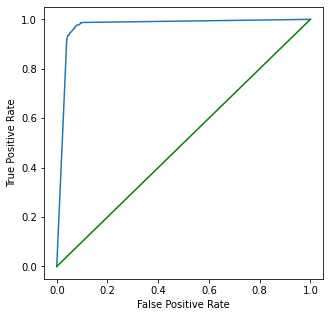

In [ ]:
test_accuracy = []
selected_features_1 = []
selected_features_2 = []
selected_features_3 = []
test_confusion_matrix = None
plot_name = ''
print(' FEATURE SELECTION USING GA \n\n')
classifiers = ['DecisionTree', 'SVM', 'RandomForest', 'NaiveBayes', 'KNeighbors']

    
for classifier in classifiers:
      print('\n\n' + classifier)
      dataset, features_dataset, labels_dataset, feature_names_dataset = get_data()
      (train, test, train_labels, test_labels) = train_test_split(features_dataset, 
                                                                labels_dataset, test_size=0.2, 
                                                                        random_state=0)
    
            test_accuracy, test_confusion_matrix, dataset_3_confusion_mat = train_evaluate_ML_classifier(classifier,train, train_labels, test, test_labels)
           
      test_acc, specificity, precision, recall, f1_score = get_scores(test_confusion_matrix)
      print("Accuracy:"+str(test_acc))
      print("Specificity:"+str(specificity))
      print("Precision:"+str(precision))
      print("Recall:"+str(recall))
      print("F1 Score:"+str(f1_score))
     
             

In [ ]:
test_accuracy = []
selected_features_1 = []
selected_features_2 = []
selected_features_3 = []
test_confusion_matrix = None
plot_name = ''
print(' FEATURE SELECTION USING GA \n\n')
classifiers = ['DecisionTree', 'SVM', 'RandomForest', 'NaiveBayes', 'KNeighbors']

    
for classifier in classifiers:
      print('\n\n' + classifier)
      dataset, features_dataset, labels_dataset, feature_names_dataset = get_data()
      (train, test, train_labels, test_labels) = train_test_split(features_dataset, 
                                                                labels_dataset, test_size=0.2, 
                                                                        random_state=0)
    
      
      test_accuracy, test_confusion_matrix, dataset_3_confusion_mat = train_evaluate_ML_classifier(classifier,train, train_labels, test, test_labels)
           
      test_acc, specificity, precision, recall, f1_score = get_scores(test_confusion_matrix)
      print("Accuracy:"+str(test_acc))
      print("Specificity:"+str(specificity))
      print("Precision:"+str(precision))
      print("Recall:"+str(recall))
      print("F1 Score:"+str(f1_score))
     
             

 FEATURE SELECTION USING GA 




DecisionTree
Time to train DecisionTree on Dataset  is: 0.025194883346557617
Accuracy:0.9457259158751696
Specificity:0.9408284023668639
Precision:0.949874686716792
Recall:0.949874686716792
F1 Score:0.949874686716792


SVM


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


Time to train SVM on Dataset  is: 0.2623939514160156
Accuracy:0.9185888738127544
Specificity:0.8895463510848126
Precision:0.9097502014504432
Recall:0.9431913116123642
F1 Score:0.9261689909762101


RandomForest


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  "X does not have valid feature names, but"


Time to train RandomForest on Dataset  is: 1.052783727645874
Accuracy:0.9547715965626413
Specificity:0.9437869822485208
Precision:0.9529314616019818
Recall:0.9640768588137009
F1 Score:0.9584717607973422


NaiveBayes
Time to train NaiveBayes on Dataset  is: 0.02089381217956543
Accuracy:0.6096788783355948
Specificity:1.0
Precision:1.0
Recall:0.27903091060985796
F1 Score:0.4363161332462443


KNeighbors


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  "X does not have valid feature names, but"


Time to train KNeighbors on Dataset  is: 0.46715855598449707


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


Accuracy:0.9502487562189055
Specificity:0.9319526627218935
Precision:0.9436734693877551
Recall:0.9657477025898078
F1 Score:0.9545829892650701


In [ ]:
test.shape

(2211, 19)

# Different Models - CatBoost

In [ ]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 63 kB/s 


In [ ]:
#  catboost Classifier Model
from catboost import CatBoostClassifier

# instantiate the model
cat = CatBoostClassifier(learning_rate  = 0.1)

# fit the model 
cat.fit(X_train,y_train)

In [ ]:
#predicting the target value from the model for the samples
y_train_cat = cat.predict(X_train)
y_test_cat = cat.predict(X_test)

In [ ]:
import sklearn.metrics as metrics

In [ ]:
acc_train_cat  = metrics.accuracy_score(y_train,y_train_cat) *100
acc_test_cat = metrics.accuracy_score(y_test,y_test_cat) *100
print("CatBoost Classifier : Accuracy on training Data: {:.3f}%".format(acc_train_cat))
print("CatBoost Classifier : Accuracy on test Data: {:.3f}%".format(acc_test_cat))

CatBoost Classifier : Accuracy on training Data: 98.992%
CatBoost Classifier : Accuracy on test Data: 97.166%


In [ ]:
#  catboost Classifier Model
from catboost import CatBoostClassifier

# instantiate the model
cat = CatBoostClassifier(learning_rate  = 0.1)

# fit the model 
cat.fit(rX_train,ry_train)

In [ ]:
#predicting the target value from the model for the samples
ry_train_cat = cat.predict(rX_train)
ry_test_cat = cat.predict(rX_test)

In [ ]:
racc_train_cat  = metrics.accuracy_score(ry_train,ry_train_cat) *100
racc_test_cat = metrics.accuracy_score(ry_test,ry_test_cat) *100
print("CatBoost Classifier : Accuracy on training Data: {:.3f}%".format(racc_train_cat))
print("CatBoost Classifier : Accuracy on test Data: {:.3f}%".format(racc_test_cat))

CatBoost Classifier : Accuracy on training Data: 98.191%
CatBoost Classifier : Accuracy on test Data: 96.473%



# Different Model - Gradient Boost

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(max_depth=4,learning_rate=0.7)

gbc.fit(X_train,y_train)

GradientBoostingClassifier(learning_rate=0.7, max_depth=4)

In [ ]:
y_train_gbc = gbc.predict(X_train)
y_test_gbc = gbc.predict(X_test)

In [ ]:
acc_train_gbc = metrics.accuracy_score(y_train,y_train_gbc) *100
acc_test_gbc = metrics.accuracy_score(y_test,y_test_gbc) *100
print("Gradient Boosting Classifier : Accuracy on training Data: {:.3f}%".format(acc_train_gbc))
print("Gradient Boosting Classifier : Accuracy on test Data: {:.3f}%".format(acc_test_gbc)) 

Gradient Boosting Classifier : Accuracy on training Data: 98.837%
Gradient Boosting Classifier : Accuracy on test Data: 97.046%


In [ ]:
gbc.fit(rX_train,ry_train)

GradientBoostingClassifier(learning_rate=0.7, max_depth=4)

In [ ]:
ry_train_gbc = gbc.predict(rX_train)
ry_test_gbc = gbc.predict(rX_test)

In [ ]:
racc_train_gbc = metrics.accuracy_score(ry_train,ry_train_gbc) *100
racc_test_gbc = metrics.accuracy_score(ry_test,ry_test_gbc) *100
print("Gradient Boosting Classifier : Accuracy on training Data: {:.3f}%".format(racc_train_gbc))
print("Gradient Boosting Classifier : Accuracy on test Data: {:.3f}%".format(racc_test_gbc)) 

Gradient Boosting Classifier : Accuracy on training Data: 97.984%
Gradient Boosting Classifier : Accuracy on test Data: 96.262%


# Storing and Comparing models

In [ ]:
ML_Model = []
accuracywoga = []
accuracywga = []

def storeResults(model, a,b):
  ML_Model.append(model)
  accuracywoga.append(round(a, 3))
  accuracywga.append(round(b, 3))

In [ ]:
storeResults('K-Nearest Neighbors',acc,racc)

In [ ]:
storeResults('CatBoost Classifier',acc_test_cat,racc_test_cat)

In [ ]:
storeResults('Gradient Boosting Classifier',acc_test_gbc, racc_test_gbc)

In [ ]:
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy w/o GA' : accuracywoga,
                        'Accuracy w GA' : accuracywga,
                      })

In [ ]:
result

,ML Model,Accuracy w/o GA,Accuracy w GA
0,K-Nearest Neighbors,94.181,94.181
1,CatBoost Classifier,97.166,96.473
2,Gradient Boosting Classifier,97.046,96.262
